(hsgp)=
# Gaussian Processes: HSGP Reference & First Steps

:::{post} June 10, 2024
:tags: gaussian processes
:category: reference, intermediate
:author: Bill Engels, Alexandre Andorra
:::

The Hilbert Space Gaussian processes approximation is a low-rank GP approximation that is particularly well-suited to usage in probabilistic programming languages like PyMC.  It approximates the GP using a pre-computed and fixed set of basis functions that don't depend on the form of the covariance kernel or its hyperparameters.  It's a _parametric_ approximation, so prediction in PyMC can be done as one would with a linear model via `pm.Data` or `pm.set_data`.  You don't need to define the `.conditional` distribution that non-parameteric GPs rely on.  This makes it _much_ easier to integrate an HSGP, instead of a GP, into your existing PyMC model.  Additionally, unlike many other GP approximations, HSGPs can be used anywhere within a model and with any likelihood function.  

It's also fast.  The computational cost for unapproximated GPs per MCMC step is $\mathcal{O}(n^3)$, where $n$ is the number of data points.  For HSGPs, it is $\mathcal{O}(mn + m)$, where $m$ is the number of basis vectors.  It's important to note that _sampling speeds_ are also very strongly determined by posterior geometry. 

The HSGP approximation does carry some restrictions:
1. It **can only be used with _stationary_ covariance kernels** such as the Matern family.  The {class}`~pymc.gp.HSGP` class is compatible with any `Covariance` class that implements the `power_spectral_density` method.  There is a special case made for the `Periodic` covariance, which is implemented in PyMC by The {class}`~pymc.gp.HSGPPeriodic`.
2. It **does not scale well with the input dimension**.  The HSGP approximation is a good choice if your GP is over a one dimensional process like a time series, or a two dimensional spatial point process.  It's likely not an efficient choice where the input dimension is larger than three. 
3. It **_may_ struggle with more rapidly varying processes**.  If the process you're trying to model changes very quickly relative to the extent of the domain, the HSGP approximation may fail to accurately represent it.  We'll show in later sections how to set the accuracy of the approximation, which involves a trade-off between the fidelity of the approximation and the computational complexity.
4. **For smaller data sets, the full unapproximated GP may still be more efficient**.

A secondary goal of this implementation is flexibility via an accessible implementation where the core computations are implemented in a modular way.  For basic usage, users can use the `.prior` and `.conditional` methods and essentially treat the HSGP class as a drop in replacement for `pm.gp.Latent`, the unapproximated GP.  More advanced users can bypass those methods and work with `.prior_linearized` instead, which exposes the HSGP as a parametric model.  For more complex models with multiple HSGPs, users can work directly with functions like `pm.gp.hsgp_approx.calc_eigenvalues` and `pm.gp.hsgp_approx.calc_eigenvectors`.

#### References:
- Original reference: [Solin & Sarkka, 2019](https://link.springer.com/article/10.1007/s11222-019-09886-w).
- HSGPs in probabilistic programming languages: [Riutort-Mayol et al., 2020](https://arxiv.org/abs/2004.11408).
- HSTPs (Student-t process): [Sellier & Dellaportas, 2023](https://proceedings.mlr.press/v202/sellier23a.html).
- Kronecker HSGPs: [Dan et al., 2022](https://arxiv.org/pdf/2210.11358.pdf)
- PyMC's {class}`~pymc.gp.HSGP` API

## Example 1: Basic HSGP Usage

We'll use simulated data to motivate an overview of the usage of {class}`~pymc.gp.HSGP`.  Refer to this section if you're interested in:
1. Seeing a simple example of `HSGP` in action.
2. Replacing a standard GP, i.e. `pm.gp.Latent`, with a faster approximation -- as long as you're using one of the more common covariance kernels, like `ExpQuad`, `Matern52` or `Matern32`.
3. Understanding when to use the centered or the non-centered parameterization.
4. A quick example of additive GPs

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm
import pytensor.tensor as pt

# Sample on the CPU
%env CUDA_VISIBLE_DEVICES=''
# import jax
# import numpyro
# numpyro.set_host_device_count(6)

env: CUDA_VISIBLE_DEVICES=''


In [2]:
az.style.use("arviz-whitegrid")
plt.rcParams["figure.figsize"] = [12, 5]
%config InlineBackend.figure_format = 'retina'
seed = sum(map(ord, "hsgp"))
rng = np.random.default_rng(seed)

### Simulate data

In [3]:
def simulate_1d(x, ell_true, eta_true, sigma_true):
    """Given a domain x, the true values of the lengthscale ell, the
    scale eta, and the noise sigma, simulate a one-dimensional GP
    observed at the given x-locations.
    """

    # Draw one sample from the underlying GP.
    n = len(x)
    cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)
    gp_true = pm.MvNormal.dist(mu=np.zeros(n), cov=cov_func(x[:, None]))
    f_true = pm.draw(gp_true, draws=1, random_seed=rng)

    # The observed data is the latent function plus a small amount
    # of Gaussian distributed noise.
    noise_dist = pm.Normal.dist(mu=0.0, sigma=sigma_true)
    y_obs = f_true + pm.draw(noise_dist, draws=n, random_seed=rng)
    return y_obs, f_true

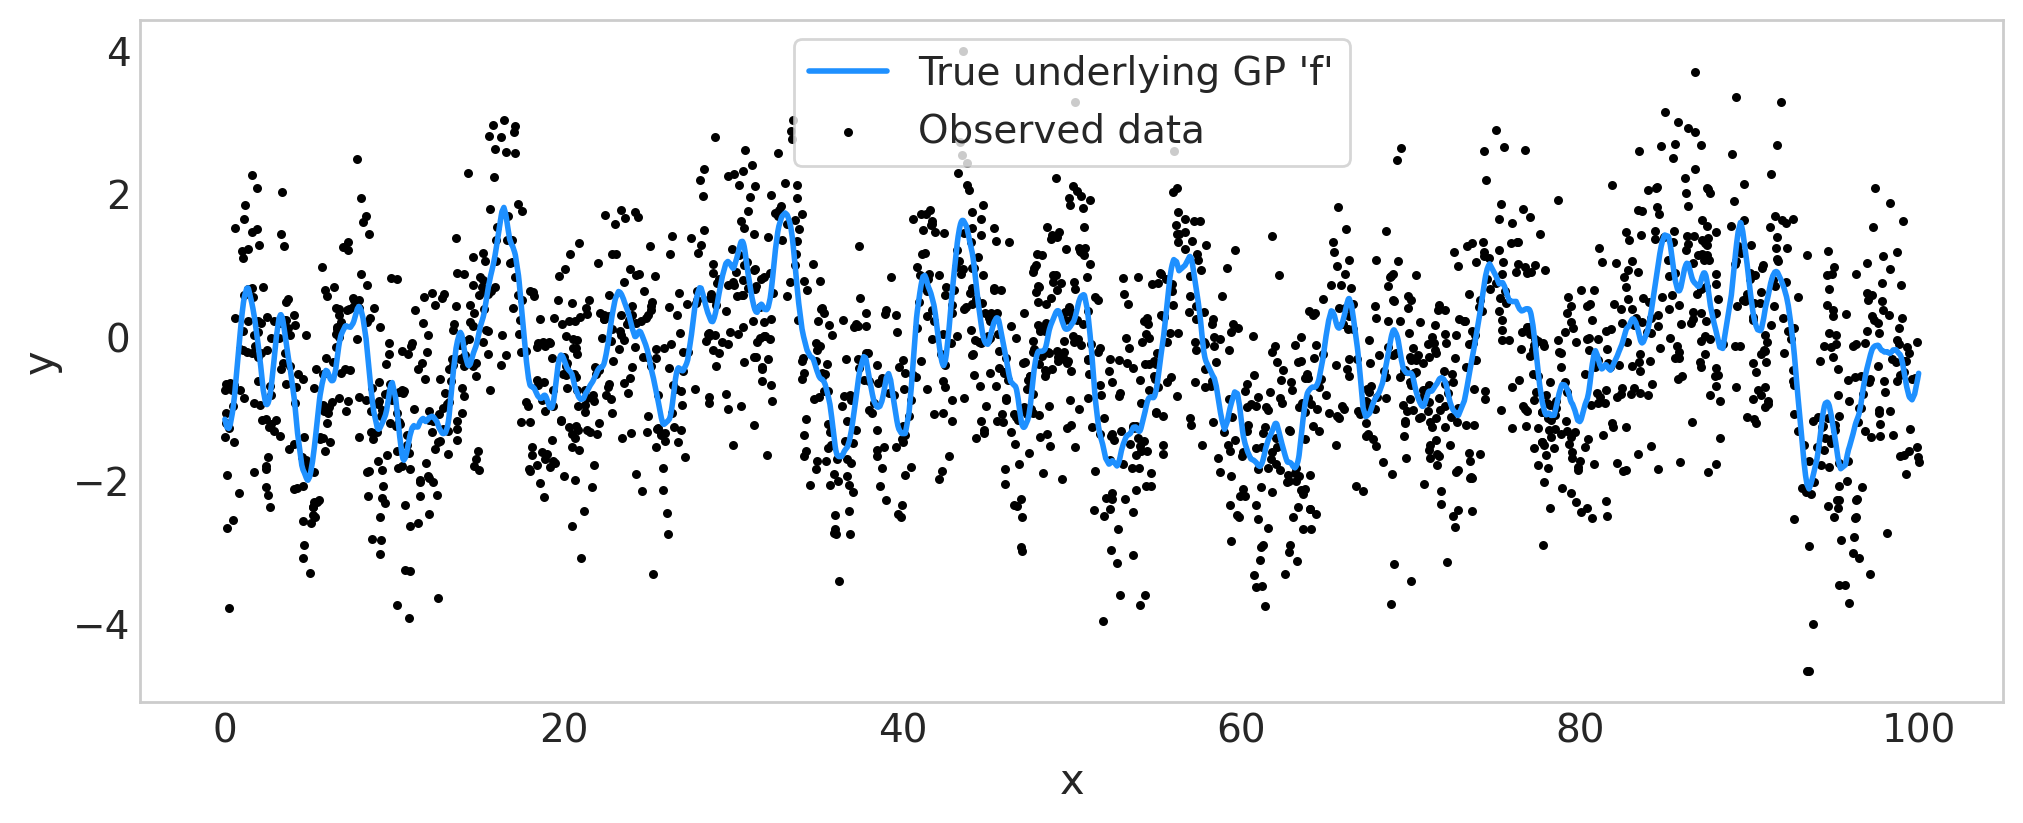

In [4]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

x = 100.0 * np.sort(np.random.rand(2000))
y_obs, f_true = simulate_1d(x=x, ell_true=1.0, eta_true=1.0, sigma_true=1.0)
ax.plot(x, f_true, color="dodgerblue", lw=2, label="True underlying GP 'f'")
ax.scatter(x, y_obs, marker="o", color="black", s=5, label="Observed data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(frameon=True)
ax.grid(False)

### Define and fit the HSGP model

First we use `pz.maxent` to choose our prior for the lengthscale parameter, maxent return the maximum entropy prior with the specified `mass` within the interval [`lower`, `upper`].  

We use a Lognormal to penalize very small lengthscales while having a heavy right tail.  When the signal from the GP is high relative to the noise, we are able to use more informative priors.

Text(0.5, 1.0, 'Prior for the lengthscale, $\\ell$')

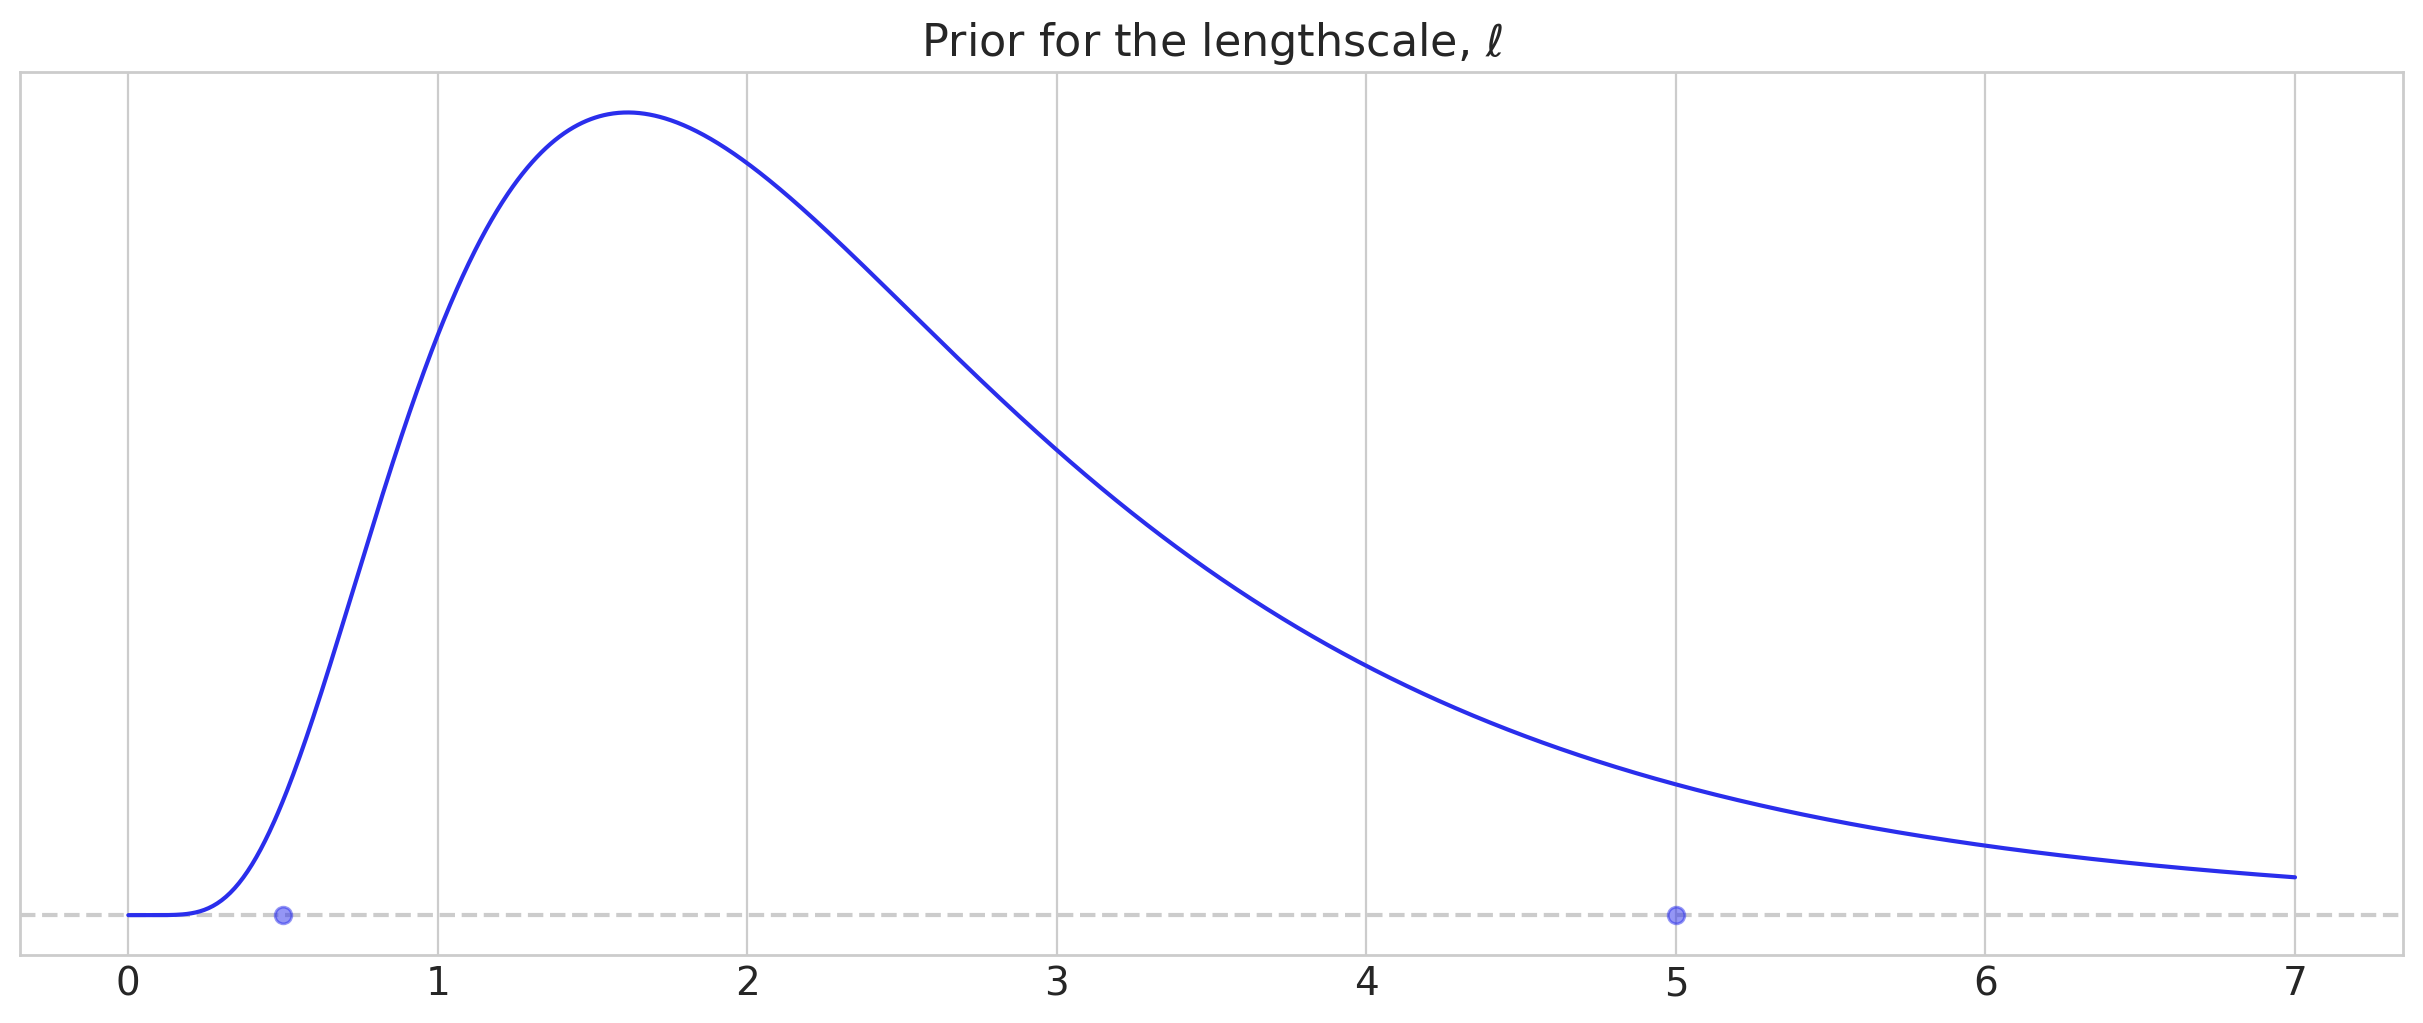

In [5]:
lower, upper = 0.5, 5.0
ell_dist, ax = pz.maxent(
    pz.LogNormal(),
    lower=lower,
    upper=upper,
    mass=0.9,
    plot_kwargs={"support": (0, 7), "legend": None},
)

ax.set_title(r"Prior for the lengthscale, $\ell$")

There are a few things to note about the model code below:
- The approximation parameters `m` and `c` control the approximation fidelity to computational complexity tradeoff.  We'll see in a later section how to choose these values.  In short, choosing a larger `m` helps improve the approximation of smaller lengthscales and other short distance variations that the GP has to fit.  Choosing a larger `c` helps improve the approximation of longer and slower changes. 
- We chose the `centered` parameterization because the true underlying GP is strongly informed by the data.  You can read more about centered vs. non-centered [here](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) and [here](https://arxiv.org/abs/1312.0906).  In the `HSGP` class, the default is `non-centered`, which works better for the, arguably more common, case where the underlying GP is weakly informed by the observed data.

In [6]:
with pm.Model(coords={"basis_coeffs": np.arange(200), "obs_id": np.arange(len(y_obs))}) as model:
    ell = ell_dist.to_pymc("ell")
    eta = pm.Exponential("eta", scale=1.0)
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell)

    # m and c control the fidelity of the approximation
    m, c = 200, 1.5
    parametrization = "centered"
    gp = pm.gp.HSGP(m=[m], c=c, parametrization=parametrization, cov_func=cov_func)
    # Compare to the code for the full, unapproximated GP:
    # gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x[:, None], hsgp_coeffs_dims="basis_coeffs", gp_dims="obs_id")

    sigma = pm.Exponential("sigma", scale=1.0)
    pm.Normal("y_obs", mu=f, sigma=sigma, observed=y_obs, dims="obs_id")

    idata = pm.sample()
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, eta, f_hsgp_coeffs_, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.
Sampling: [y_obs]


Output()

In [7]:
az.summary(idata, var_names=["eta", "ell", "sigma"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
eta    0.91  0.08    0.77     1.07        0.0      0.0   3468.12   3062.29   
ell    0.94  0.10    0.76     1.13        0.0      0.0   1476.96   2829.41   
sigma  1.01  0.02    0.98     1.04        0.0      0.0   8891.85   3058.98   

       r_hat  
eta      1.0  
ell      1.0  
sigma    1.0

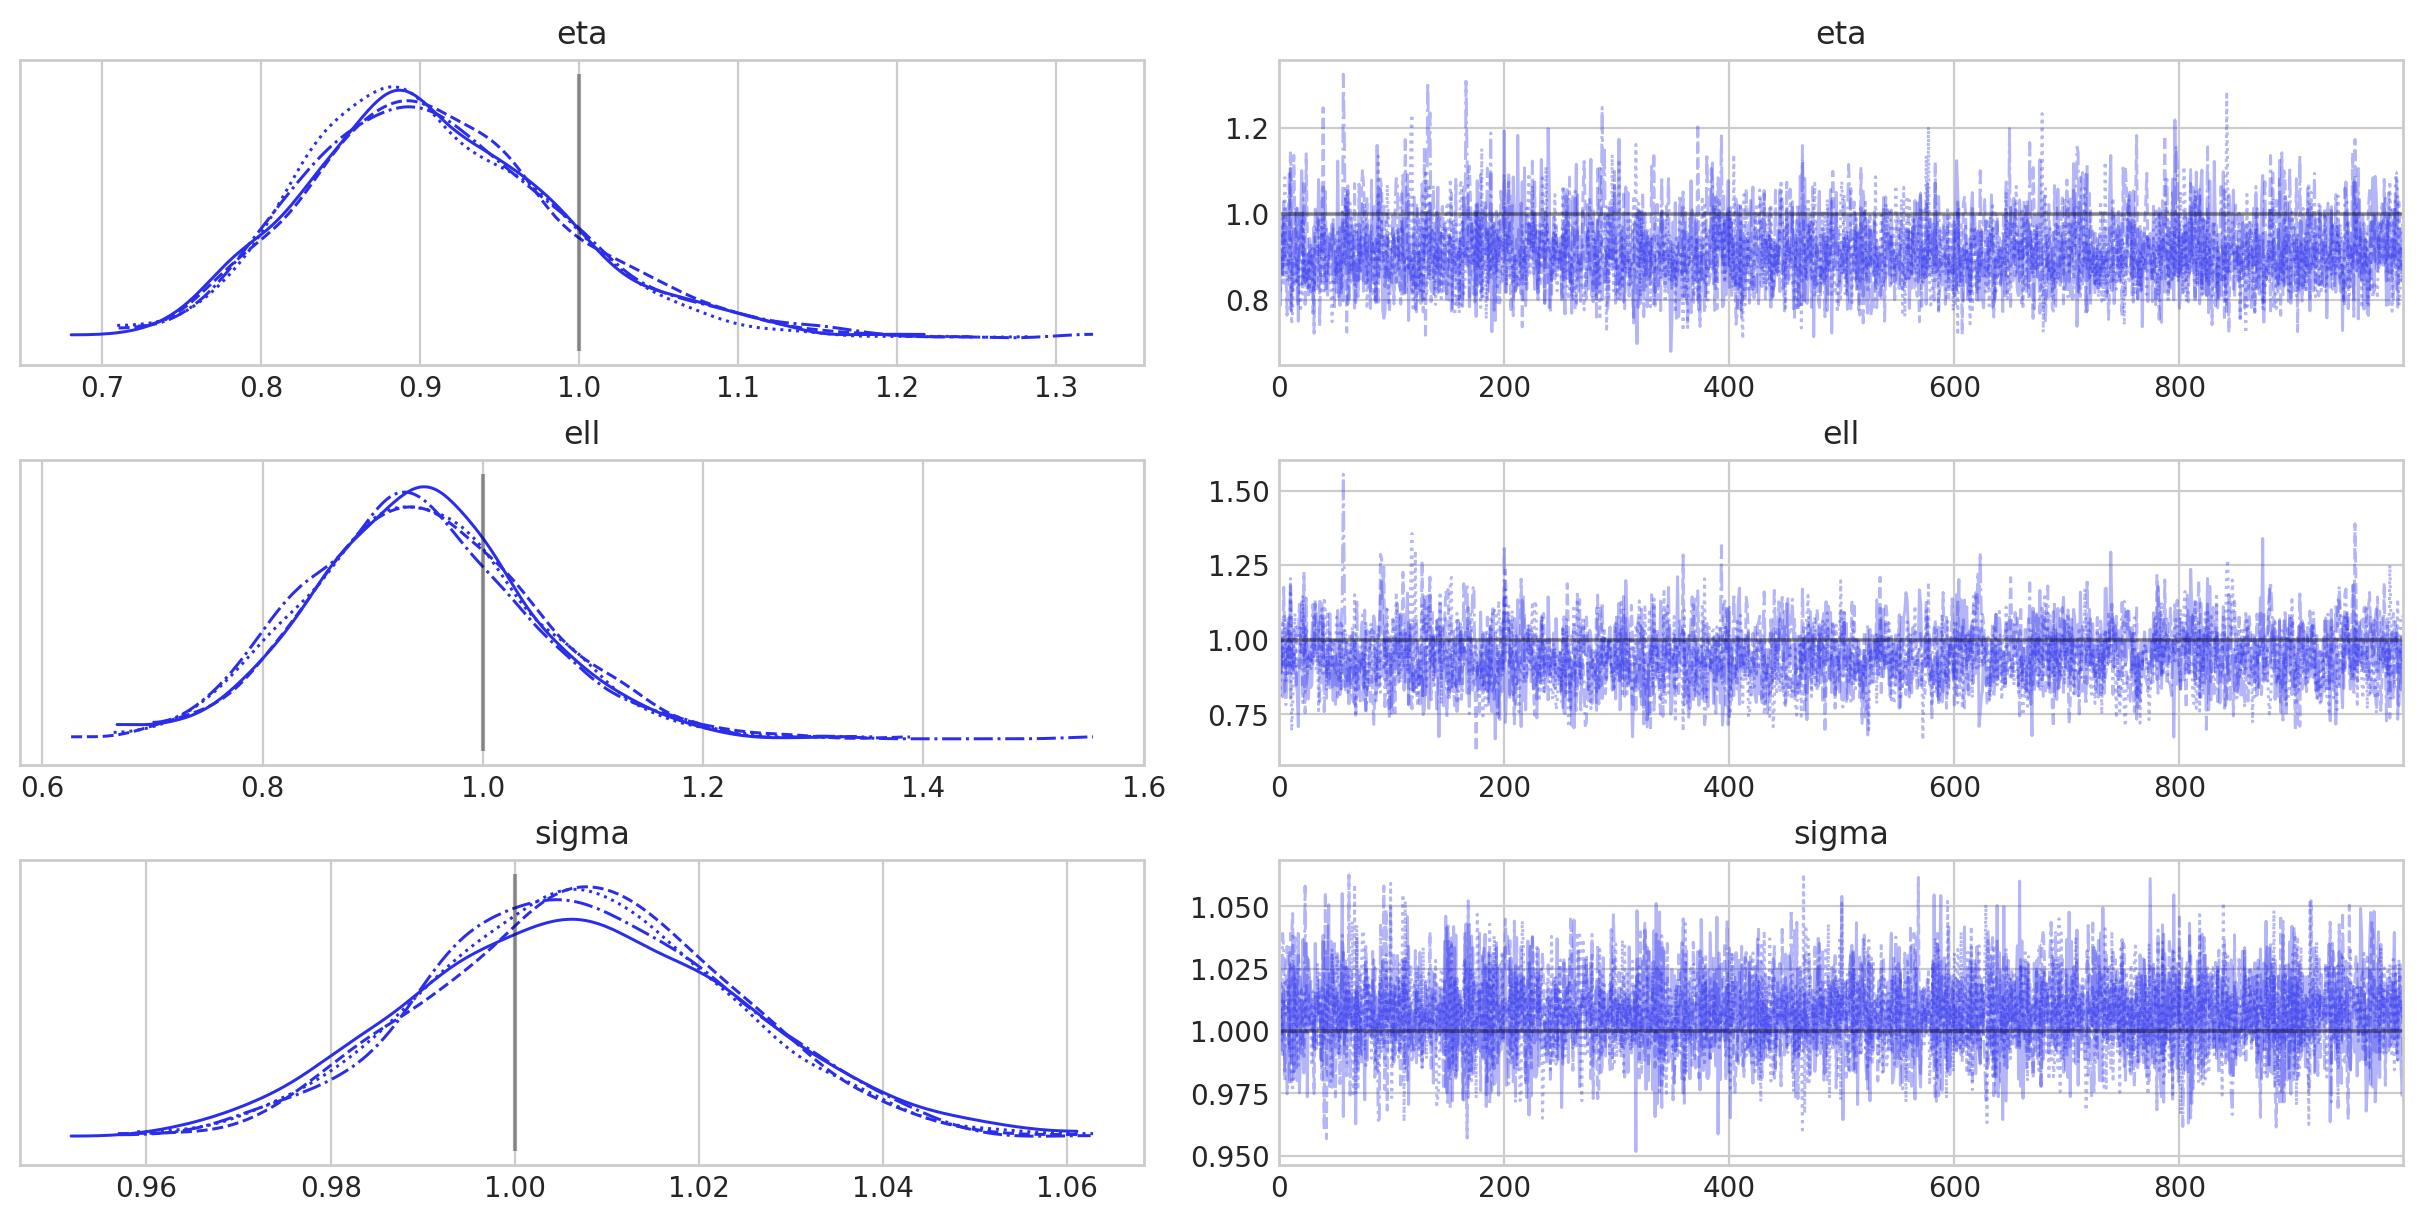

In [8]:
az.plot_trace(
    idata,
    var_names=["eta", "ell", "sigma"],
    lines=[("eta", {}, [1]), ("ell", {}, [1]), ("sigma", {}, [1])],
);

Fitting went all good, so we can go ahead and plot the inferred GP, as well as the posterior predictive samples.

### Posterior predictive plot

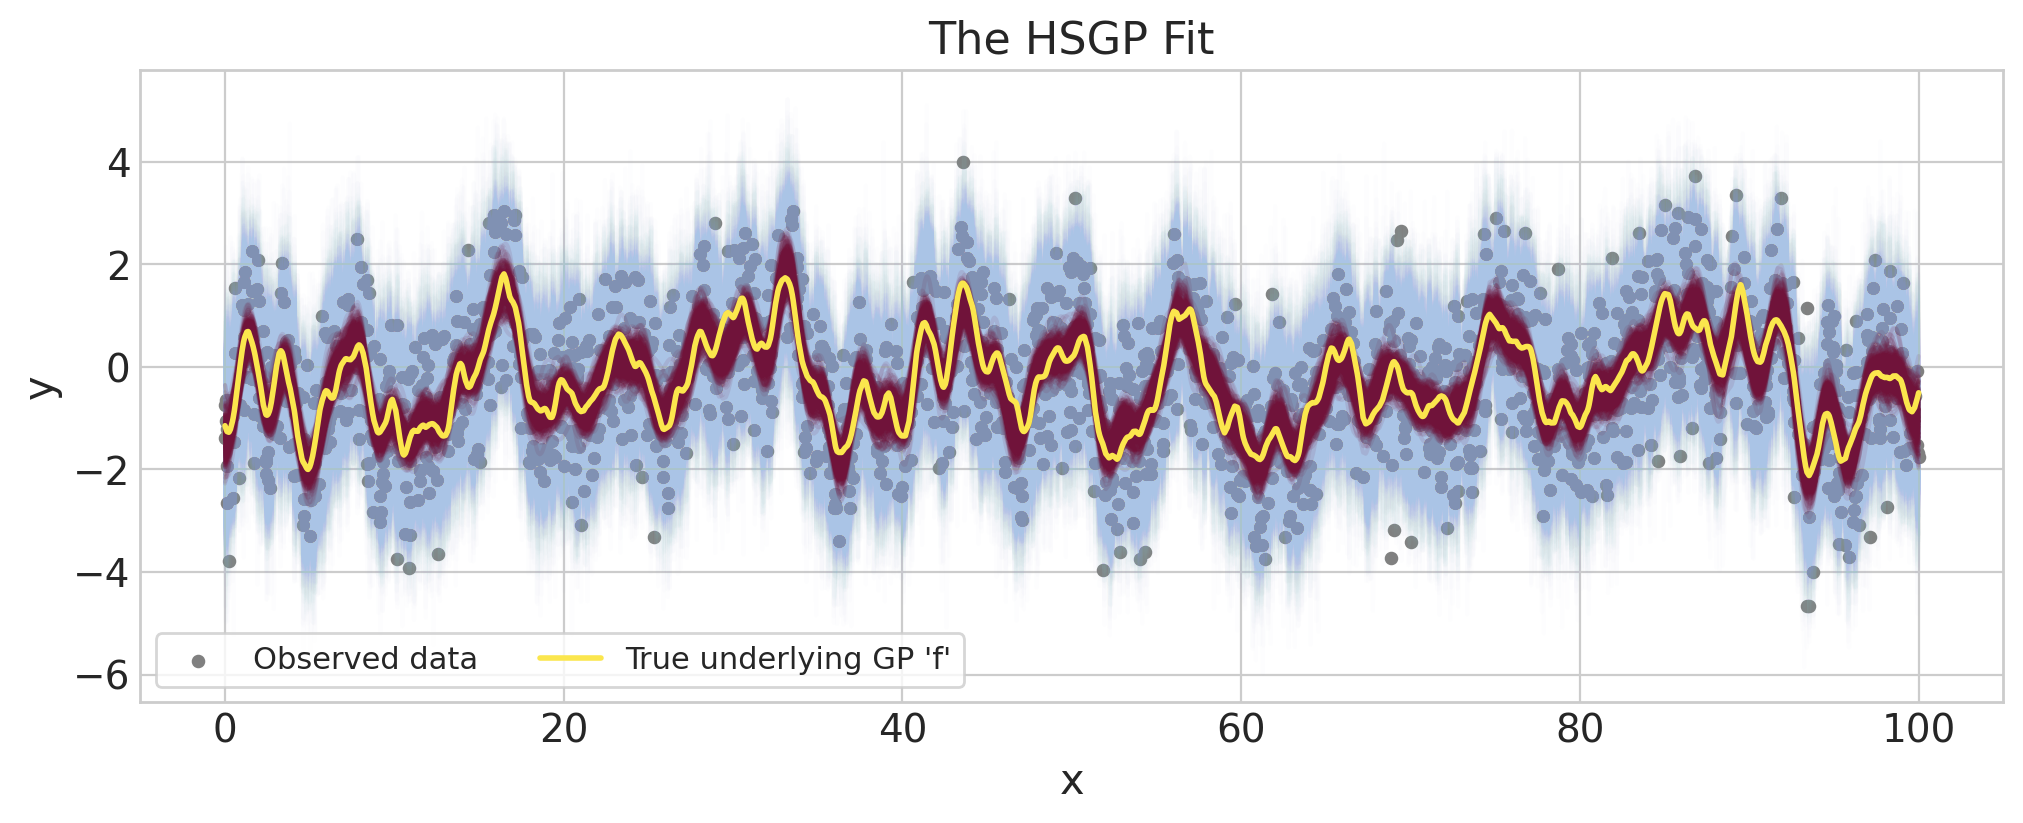

In [9]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f = az.extract(idata.posterior.sel(draw=slice(None, None, 10)), var_names="f")
y_preds = az.extract(idata.posterior_predictive.sel(draw=slice(None, None, 10)), var_names="y_obs")

ax.plot(x, y_preds, color="#AAC4E6", alpha=0.02)
ax.plot(x, f, color="#70133A", alpha=0.1)
ax.scatter(x, y_obs, marker="o", color="grey", s=15, label="Observed data")
ax.plot(x, f_true, color="#FBE64D", lw=2, label="True underlying GP 'f'")

ax.set(title="The HSGP Fit", xlabel="x", ylabel="y")
ax.legend(frameon=True, fontsize=11, ncol=2);

The inferred underlying GP (in bordeaux) accurately matches the true underlying GP (in yellow). We also see that the posterior predictive samples (in light blue) fit the observed data really well.

`````{admonition} Additive GPs
:class: tip
{class}`~pymc.gp.HSGP` is compatible with additive covariances, instead of defining two completely independent HSGPs. 

Instead of constructing and then directly adding them, the sum of two HSGPs can be computed more efficiently by first taking the sum of their power spectral densities, and then creating a single GP from the combined power spectral density. This reduces the number of unknown parameters because the two GPs can share the same basis set.

The code for this would look similar to:
```python
cov1 = eta1**2 * pm.gp.cov.ExpQuad(input_dim, ls=ell1)
cov2 = eta2**2 * pm.gp.cov.Matern32(input_dim, ls=ell2)
cov = cov1 + cov2

gp = pm.gp.HSGP(m=[m], c=c, cov_func=cov_func)
```
``````

## Choosing the HSGP approximation parameters, `m`, `L`, and `c`

Before fitting a model with an HSGP, you have to choose `m` and `c` or `L`.  **`m` is the number of basis vectors**. Recall that the computational complexity of the HSGP approximation is $\mathcal{O}(mn + m)$, where $n$ is the number of data points. 

This choice is a balance between three concerns:
1.  The accuracy of the approximation.
2.  Reducing the computational burden.
3.  The `X` locations where predictions or forecasts will need to be made.

At the end of this section, we'll give the rules of thumb given in [Ruitort-Mayol et. al.](https://arxiv.org/abs/2004.11408). The best way to understand how to choose these parameters is to understand how `m`, `c` and `L` relate to each other, which requires understanding a bit more about how the approximation works under the hood.

### How `L` and `c` affect the basis

Speaking non-technically, the HSGP approximates the GP prior as a linear combination of sinusoids.  The coefficients of the linear combination are IID normal random variables whose standard deviation depends on GP hyperparameters (which are an amplitude and lengthscale for the Matern family). 

To see this, we'll make a few plots of the $m=3$ and $m=5$ basis vectors and pay careful attention to how they behave at the boundaries of the domain.  Note that we have to center the `x` data first, and then choose `L` in relation to the centered data.  It's worth mentioning here that the basis vectors we're plotting do not depend on either the choice of the covariance kernel or on any unknown parameters the covariance function has.

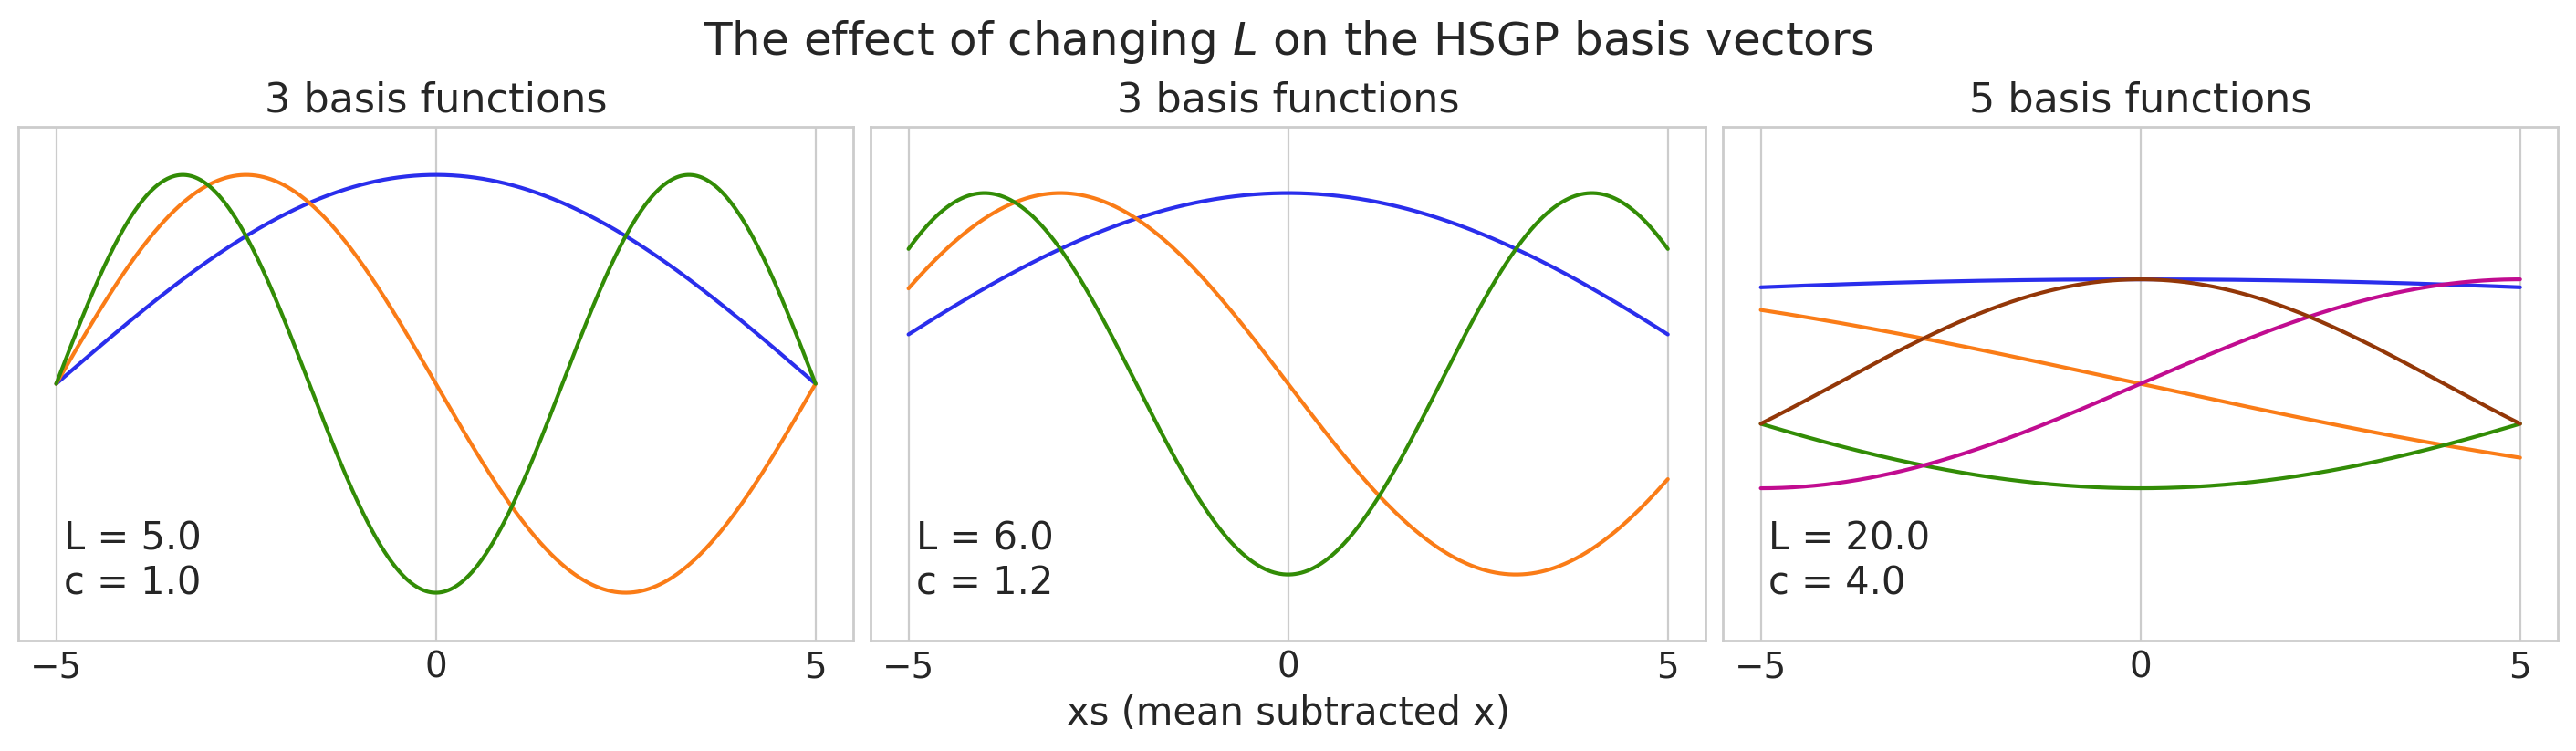

In [10]:
# Our data goes from x=-5 to x=5
x = np.linspace(-5, 5, 1000)

# (plotting code)
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True, constrained_layout=True)

ylim = 0.55
axs[0].set_ylim([-ylim, ylim])
axs[1].set_yticks([])
axs[1].set_xlabel("xs (mean subtracted x)")
axs[2].set_yticks([])

# change L as we create the basis vectors
L_options = [5.0, 6.0, 20.0]
m_options = [3, 3, 5]
for i, ax in enumerate(axs.flatten()):
    L = L_options[i]
    m = m_options[i]

    eigvals = pm.gp.hsgp_approx.calc_eigenvalues(pt.as_tensor([L]), [m])
    phi = pm.gp.hsgp_approx.calc_eigenvectors(
        x[:, None],
        pt.as_tensor([L]),
        eigvals,
        [m],
    ).eval()

    for j in range(phi.shape[1]):
        ax.plot(x, phi[:, j])

    ax.set_xticks(np.arange(-5, 6, 5))

    S = 5.0
    c = L / S
    ax.text(-4.9, -0.45, f"L = {L}\nc = {c}", fontsize=15)
    ax.set(title=f"{m} basis functions")

plt.suptitle("The effect of changing $L$ on the HSGP basis vectors", fontsize=18);

The first and middle panels have 3 basis functions, and the rightmost has 5.

Notice that both `L` and `m` are specified as lists, to allow setting `L` and `m` per input dimension.  In this example these are both one element lists since our example is in a one dimensional, time series like context.  Before continuing, it's helpful to define $S$ as the half range of the centered data, or the distance from the midpoint at $x=0$ to the edge, $x=5$.  In this example $S=5$ for each plot panel.  Then, we can define $c$ such that it relates $S$ to $L$, 
$$
L = c \cdot S \,.
$$
It's usually easier to set $L$ by choosing $c$, which acts as a multiplier on $S$.  

In the left-most plot we chose $L=S=5$, which is exactly on the edge of our `x` locations.  For any $m$, all the basis vectors are forced to pinch to zero at the edges, at $x=-5$ and $x=5$.  This means that the HSGP approximation becomes poor as you get closer to $x=-5$ and $x=5$.  How quickly depends on the lengthscale.  Large lengthscales require larger values of $L$ and $c$, and smaller lengthscales attenuate this issue.  Ruitort-Mayol et. al. recommend using 1.2 as a minimum value.  The effect of this choice on the basis vectors is shown in the center panel. In particular, we can now see that the basis vectors are _not_ forced to pinch to zero.

The right panel shows the effect of choosing a larger $L$, or setting $c=4$.  Larger values of $L$ or $c$ make the boundary conditions less problematic, and are required to accurately approximate GPs with longer lengthscales. **You also need to consider where predictions will need to be made**.  In addition to the locations of the observed $x$ values, the locations of the new $x$ locations also need to be away from the "pinch" caused by the boundary condition.  The _period_ of the basis functions also increases as we increase $L$ or $c$.  This means that **we will need to increase $m$**, the number of basis vectors, **in order to compensate** if we wish to approximate GPs with smaller lengthscales.  

With large $L$ or $c$, the first eigenvector can flatten so much that it becomes partially or completely unidentifiable with the intercept in the model.  The right-most panel is an example of this (see the blue basis vector).  It can be very beneficial to sampling to drop the first eigenvector in these situations.  The `HSGP` and `HSGPPeriodic` class in PyMC both have the option `drop_first` to do this, or if you're using `.prior_linearized` you can control this yourself.  **Be sure to check the basis vectors if the sampler is having issues**.

To summarize:

- **Increasing $m$ helps the HSGP approximate GPs with smaller lengthscales**, at the cost of increasing computational complexity.
- **Increasing $c$ or $L$ helps the HSGP approximate GPs with larger lengthscales**, but may require increasing $m$ to compensate for the loss of fidelity at smaller lengthscales.  
- When choosing $m$, $c$ or $L$, it's important to **consider the locations where you will need to make predictions**, such that they also aren't affected by the boundary condition.
- **The first basis vector may be unidentified** with the intercept, especially when $L$ or $c$ are larger.

### Heuristics for choosing $m$ and $c$

In practice, you'll need to infer the lengthscale from the data, so the HSGP needs to approximate a GP across a range of lengthscales that are representative of your chosen prior. You'll need to choose **$c$ large enough to handle the largest lengthscales** you might fit, and also **choose $m$ large enough to accommodate the smallest lengthscales**.

[Ruitort-Mayol et. al.](https://arxiv.org/abs/2004.11408) give some handy heuristics for the range of lengthscales that are accurately reproduced for given values of $m$ and $c$. Below, we provide a function that uses their heuristics to recommend minimum $m$ and $c$ value. Note that **these recommendations are based on a one-dimensional GP**.

For example, if you're using the `Matern52` covariance and your data ranges from $x=-5$ to $x=95$, and the bulk of your lengthscale prior is between $\ell=1$ and $\ell=50$, then the smallest recommended values are $m=543$ and $c=3.7$, as you can see below:

In [11]:
m, c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[-5, 95], lengthscale_range=[1, 50], cov_func="matern52"
)

print("Recommended smallest number of basis vectors (m):", m)
print("Recommended smallest scaling factor (c):", np.round(c, 1))

Recommended smallest number of basis vectors (m): 543
Recommended smallest scaling factor (c): 4.1


### The HSGP approximate Gram matrix

You may not be able to rely on these heuristics for a few reasons.  You may be using a different covariance function than `ExpQuad`, `Matern52`, or `Matern32`.  Also, they're only defined for one dimensional GPs.  Another way to check HSGP fidelity is to directly compare the unapproximated Gram matrix (the Gram matrix is the matrix obtained after calculating the covariance function over the inputs `X`), $\mathbf{K}$, to the one resulting from the HSGP approximation, 
$$
\tilde{\mathbf{K}} = \Phi \Delta \Phi^T \,,
$$
where $\Phi$ is the matrix of eigenvectors we use as the basis (plotted previously), and $\Delta$ has the spectral densities computed at the eigenvalues down the diagonal.  Below we show an example with a two dimensional grid of input `X`.  It's important to notice that the HSGP approximation requires us to center the input `X` data, which is done by converting `X` to `Xs` in the code below.  We plot the approximate Gram matrix for varying $L$ and $c$ values, to see when the approximation starts to degrade for the given `X` locations and lengthscale choices.

In [12]:
## Define the X locations and calculate the Gram matrix from a given covariance function
x1, x2 = np.meshgrid(np.linspace(0, 10, 50), np.linspace(0, 10, 4))
X = np.vstack((x2.flatten(), x1.flatten())).T

# X is two dimensional, so we set input_dim=2
chosen_ell = 3.0
cov_func = pm.gp.cov.ExpQuad(input_dim=2, ls=chosen_ell)
K = cov_func(X).eval()

## Calculate the HSGP approximate Gram matrix
# Center or "scale" X so we can work with Xs (important)
X_center = (np.max(X, axis=0) + np.min(X, axis=0)) / 2.0
Xs = X - X_center

# Calculate L given Xs and c
m, c = [20, 20], 2.0
L = pm.gp.hsgp_approx.set_boundary(Xs, c)

In [13]:
def calculate_Kapprox(Xs, L, m):
    # Calculate Phi and the diagonal matrix of power spectral densities
    eigvals = pm.gp.hsgp_approx.calc_eigenvalues(L, m)
    phi = pm.gp.hsgp_approx.calc_eigenvectors(Xs, L, eigvals, m)
    omega = pt.sqrt(eigvals)
    psd = cov_func.power_spectral_density(omega)
    return (phi @ pt.diag(psd) @ phi.T).eval()

/tmp/ipykernel_21840/3948114812.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


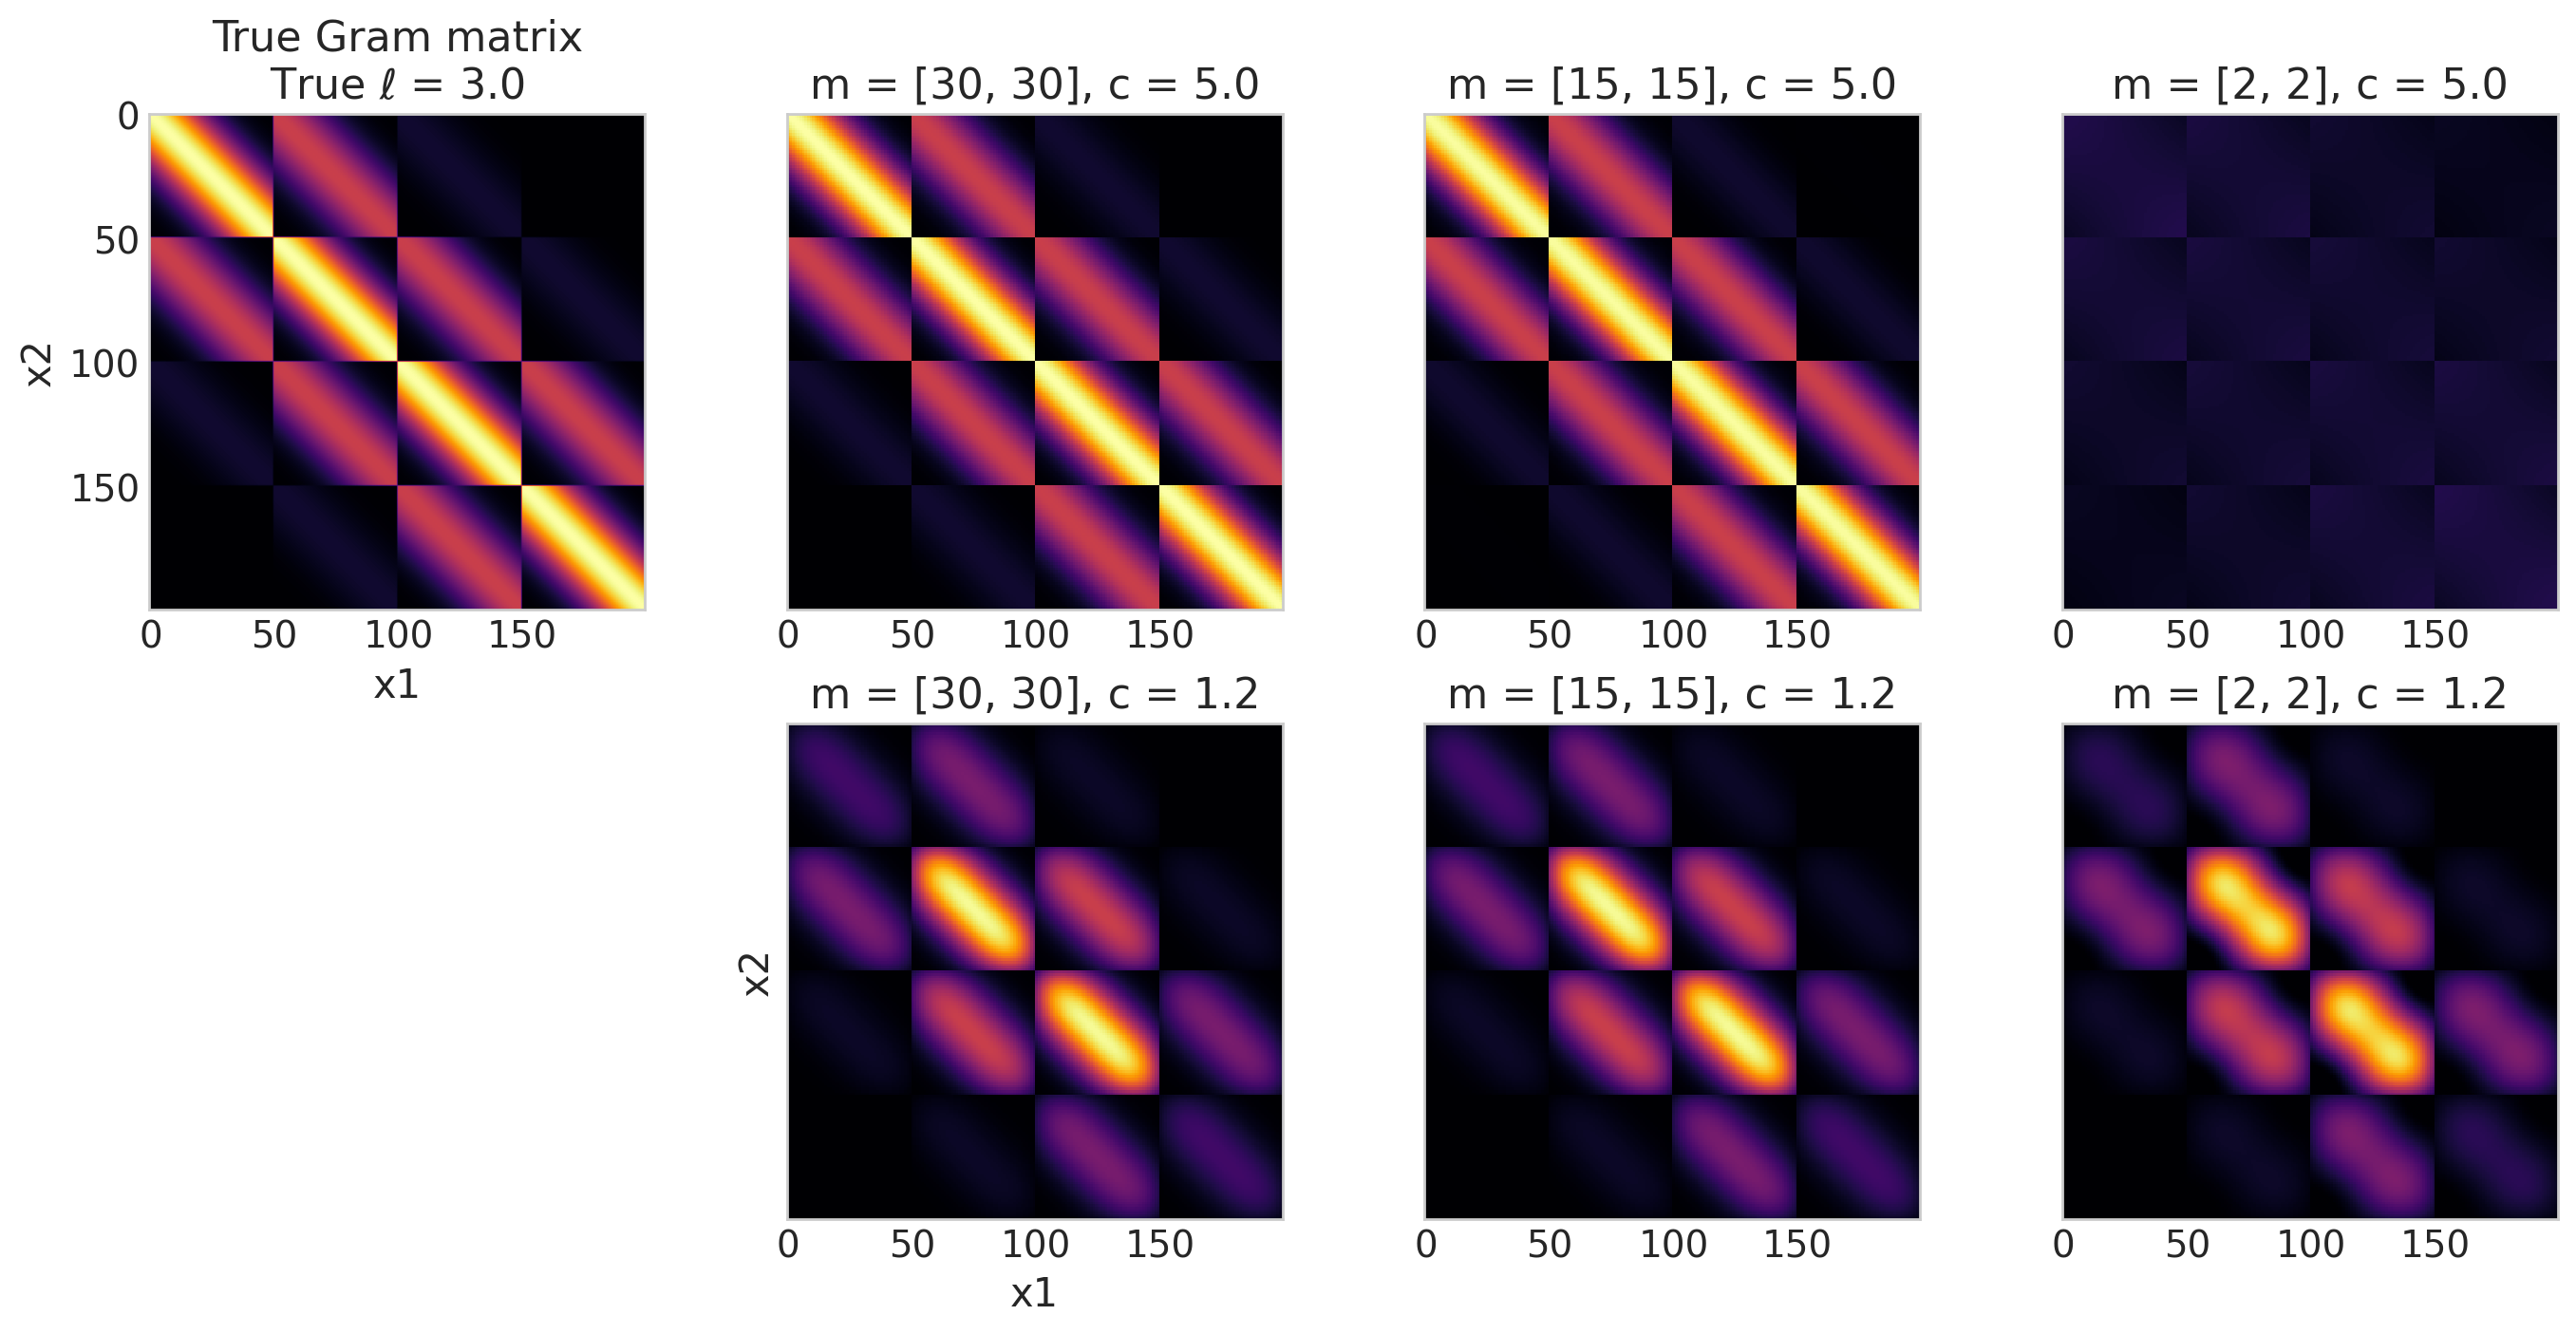

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7), sharey=True)

axs[0, 0].imshow(K, cmap="inferno", vmin=0, vmax=1)
axs[0, 0].set(xlabel="x1", ylabel="x2", title=f"True Gram matrix\nTrue $\\ell$ = {chosen_ell}")
axs[1, 0].axis("off")
im_kwargs = {
    "cmap": "inferno",
    "vmin": 0,
    "vmax": 1,
    "interpolation": "none",
}

## column 1
m, c = [30, 30], 5.0
L = pm.gp.hsgp_approx.set_boundary(Xs, c)
K_approx = calculate_Kapprox(Xs, L, m)
axs[0, 1].imshow(K_approx, **im_kwargs)
axs[0, 1].set_title(f"m = {m}, c = {c}")

m, c = [30, 30], 1.2
L = pm.gp.hsgp_approx.set_boundary(Xs, c)
K_approx = calculate_Kapprox(Xs, L, m)
axs[1, 1].imshow(K_approx, **im_kwargs)
axs[1, 1].set(xlabel="x1", ylabel="x2", title=f"m = {m}, c = {c}")

## column 2
m, c = [15, 15], 5.0
L = pm.gp.hsgp_approx.set_boundary(Xs, c)
K_approx = calculate_Kapprox(Xs, L, m)
axs[0, 2].imshow(K_approx, **im_kwargs)
axs[0, 2].set_title(f"m = {m}, c = {c}")

m, c = [15, 15], 1.2
L = pm.gp.hsgp_approx.set_boundary(Xs, c)
K_approx = calculate_Kapprox(Xs, L, m)
axs[1, 2].imshow(K_approx, **im_kwargs)
axs[1, 2].set_title(f"m = {m}, c = {c}")

## column 3
m, c = [2, 2], 5.0
L = pm.gp.hsgp_approx.set_boundary(Xs, c)
K_approx = calculate_Kapprox(Xs, L, m)
axs[0, 3].imshow(K_approx, **im_kwargs)
axs[0, 3].set_title(f"m = {m}, c = {c}")

m, c = [2, 2], 1.2
L = pm.gp.hsgp_approx.set_boundary(Xs, c)
K_approx = calculate_Kapprox(Xs, L, m)
axs[1, 3].imshow(K_approx, **im_kwargs)
axs[1, 3].set_title(f"m = {m}, c = {c}")

for ax in axs.flatten():
    ax.grid(False)
plt.tight_layout();

The plots above compare the approximate Gram matrices to the unapproximated Gram matrix in the top left panel.  The goal is to compare the approximated Gram matrices to the true one (upper left).  Qualitatively, **the more similar they look the better the approximation**.  Also, these results are **only relevant to the context of the particular domain defined by `X` and the chosen lengthscale**, $\ell = 3$ -- just because it looks good for $\ell = 3$ doesn't mean it will look good for, for instance, $\ell = 10$.  

We can make a few observations:
- The approximation visually looks good for the two panels with $m = 15$ or $m = 30$, and with $c=5.0$.  The rest show clear differences to the unapproximated Gram matrix.  
- $c=1.2$ is generally too small, regardless of $m$.
- Perhaps surprisingly, the $m=[2, 2]$, $c=1.2$ approximation looks better than the $m=[2, 2]$, $c=5$ one. As we showed earlier, when we "stretch" the eigenvector basis to fill a larger domain than our `X` (larger by the multiple $c$), we can lose fidelity at smaller lengthscales. In other words, in the second case. $m$ is too small for the value of $c$. That's why the first option looks better.
- The second row ($c=1.2$) doesn't really improve as $m$ increases. That's because $m$ is good enough to capture the smaller lengthscales, but $c$ is always too small to capture the larger lengthscales.
- The first row on the other hand shows that $c=5$ is good enough for the larger lengthscales, and once we hit $m=15$ we're also able to capture the smaller ones.

For your particular situation, **you will need to experiment across your range of lengthscales and quantify how much approximation error is acceptable**. Often, when prototyping a model, you can use a lower fidelity HSGP approximation for faster sampling. Then, once you understand the range of relevant lengthscales, you can dial in the correct $m$ and $L$ (or $c$) values.  

Be aware that it's also possible to encounter scenarios where a low fidelity HSGP approximation gives a more parsimonious fit than a high fidelity HSGP approximation. A low fidelity HSGP approximation is still a valid prior for some unknown function, if somewhat contrived. Whether that matters will depend on your context.

## Example 2: Working with HSGPs as a parametric, linear model

One of the main benefits of the HSGP approximation is the ability to integrate it into existing models, especially if you need to do prediction in new x-locations after sampling.  Unlike other GP implementations in PyMC, you can bypass the `.prior` and `.conditional` API, and instead use `HSGP.prior_linearized`, which allows you to use `pm.Data` and `pm.set_data` for making predictions. 

**Refer to this section if you're interested in:**
1. Seeing a two dimensional, or spatial, HSGP example with other predictors in the model.
2. Using HSGPs for prediction within larger PyMC models.
3. Convert your HSGP approximation into an _HSTP_ approximation, or an approximation to a TP, or Student-t process.

### Data generation

In [15]:
def simulate_2d(
    beta0_true,
    beta1_true,
    ell_true,
    eta_true,
    sigma_true,
):
    # Create the 2d X locations
    from scipy.stats import qmc

    sampler = qmc.Sobol(d=2, scramble=False, optimization="lloyd")
    X = 20 * sampler.random_base2(m=11) - 10.0

    # add the fixed effect at specific intervals
    ix = 1.0 * (np.abs(X[:, 0] // 5) == 1)
    X = np.hstack((X, ix[:, None]))

    # Draw one sample from the underlying GP
    n = X.shape[0]
    cov_func = eta_true**2 * pm.gp.cov.Matern52(3, ell_true, active_dims=[0, 1])
    gp_true = pm.MvNormal.dist(mu=np.zeros(n), cov=cov_func(X))
    f_true = pm.draw(gp_true, draws=1, random_seed=rng)

    # Add the fixed effects
    mu = beta0_true + beta1_true * X[:, 2] + f_true

    # The observed data is the latent function plus a small amount
    # of Gaussian distributed noise.
    noise_dist = pm.Normal.dist(mu=0.0, sigma=sigma_true)
    y_obs = mu + pm.draw(noise_dist, draws=n, random_seed=rng)
    return y_obs, f_true, mu, X

In [16]:
y_obs, f_true, mu, X = simulate_2d(
    beta0_true=3.0,
    beta1_true=2.0,
    ell_true=1.0,
    eta_true=1.0,
    sigma_true=0.75,
)

# Split into train and test sets
ix_tr = (X[:, 1] < 2) | (X[:, 1] > 4)
ix_te = (X[:, 1] > 2) & (X[:, 1] < 4)

X_tr, X_te = X[ix_tr, :], X[ix_te, :]
y_tr, y_te = y_obs[ix_tr], y_obs[ix_te]

/tmp/ipykernel_21840/2813859405.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.02)


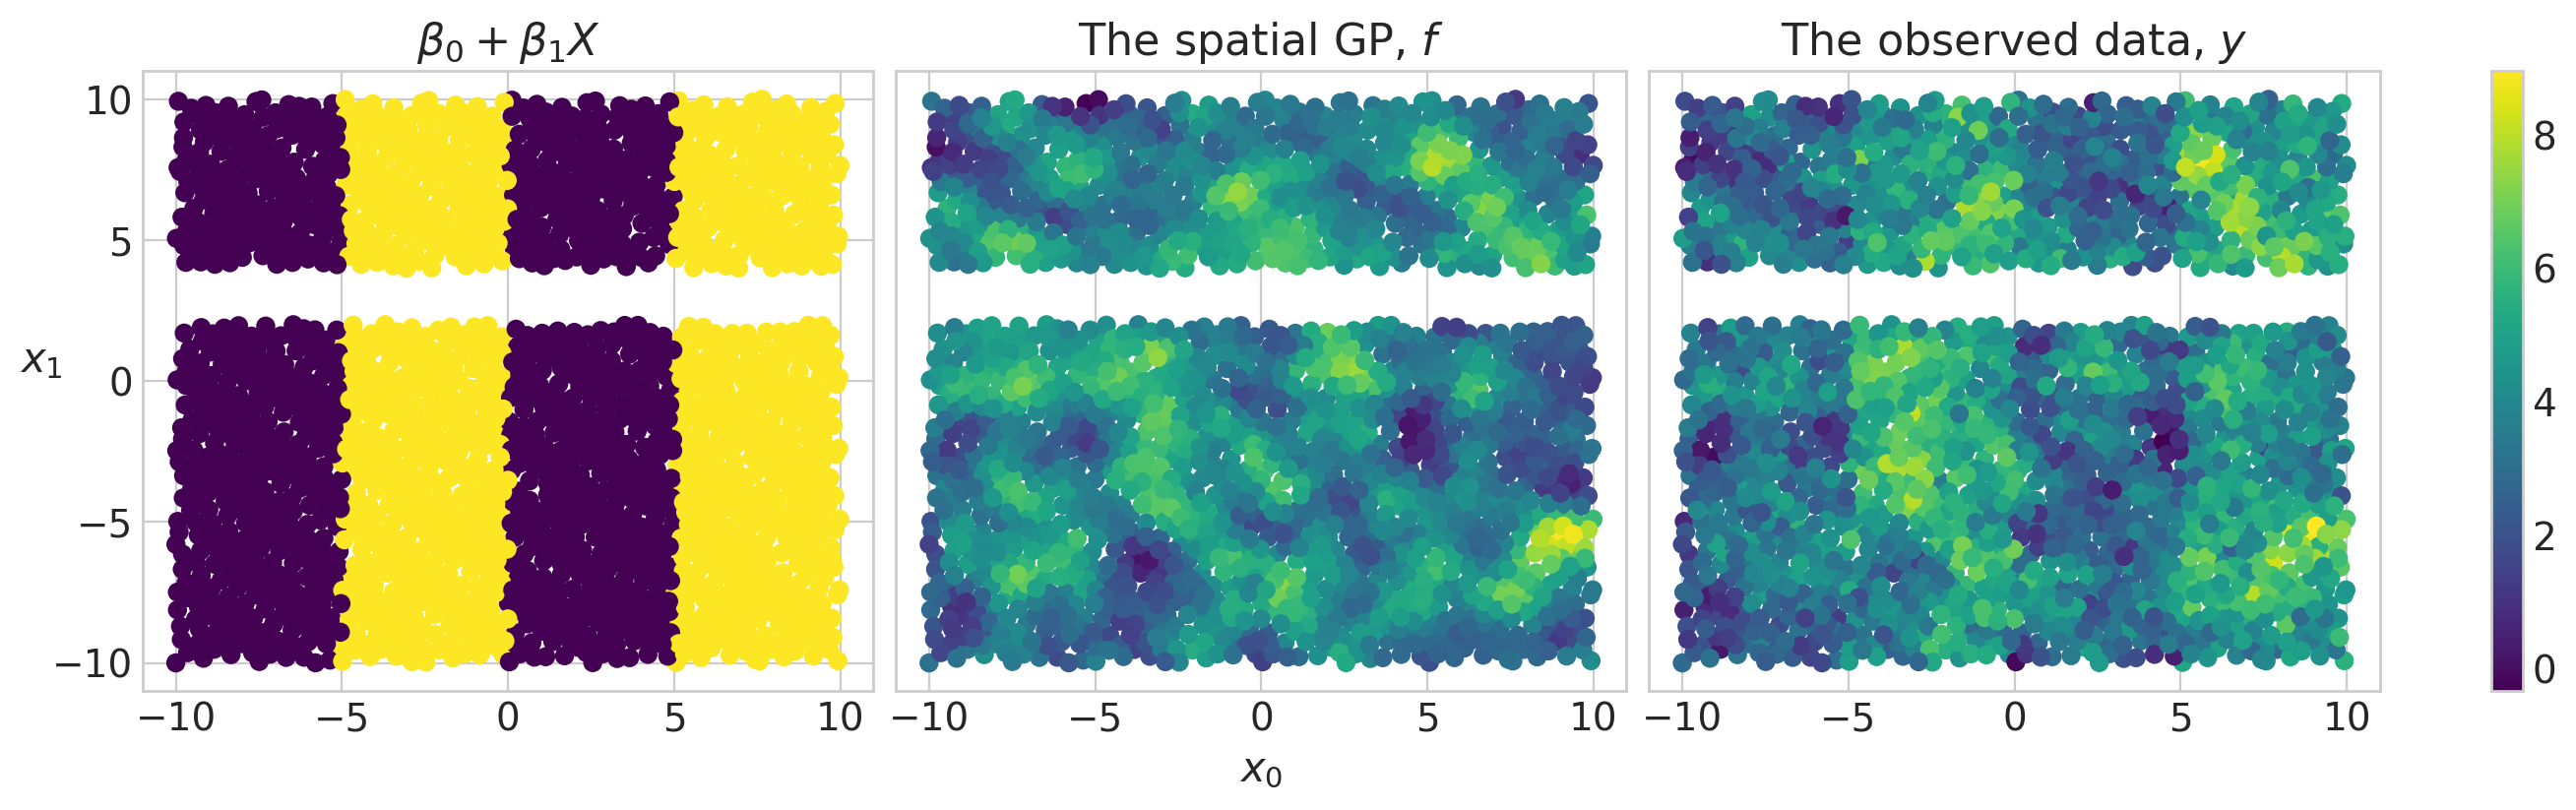

In [17]:
fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(wspace=0.02)

ax1 = plt.subplot(131)
ax1.scatter(X_tr[:, 0], X_tr[:, 1], c=mu[ix_tr] - f_true[ix_tr])
ax1.set_title("$\\beta_0 + \\beta_1 X$")
ax1.set_ylabel("$x_1$", rotation=0)

ax2 = plt.subplot(132)
ax2.scatter(X_tr[:, 0], X_tr[:, 1], c=f_true[ix_tr])
ax2.set_title("The spatial GP, $f$")
ax2.set_yticks([])
ax2.set_xlabel("$x_0$")

ax3 = plt.subplot(133)
im = ax3.scatter(X_tr[:, 0], X_tr[:, 1], c=y_obs[ix_tr])
ax3.set_title("The observed data, $y$")
ax3.set_yticks([])

fig.colorbar(im, ax=[ax1, ax2, ax3]);

As expected, we clearly see that **the test set is in the region where $2 < x1 < 4$**.

Here is the model structure corresponding to our generative scenario. Below we describe its main components.

### Model structure

Sampling: [basis_coeffs, beta, ell, eta, sigma, y_obs]


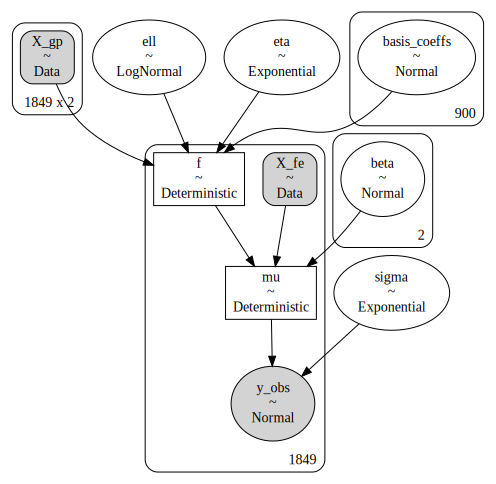

In [18]:
with pm.Model() as model:
    # Set mutable data
    X_gp = pm.Data("X_gp", X_tr[:, :2])
    X_fe = pm.Data("X_fe", X_tr[:, 2])

    # Priors on regression coefficients
    beta = pm.Normal("beta", mu=0.0, sigma=10.0, shape=2)

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=5.0, mass=0.9, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params)
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    # m and c control the fidelity of the approximation
    m0, m1, c = 30, 30, 2.0
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    f = pm.Deterministic("f", phi @ (basis_coeffs * sqrt_psd))

    mu = pm.Deterministic("mu", beta[0] + beta[1] * X_fe + f)

    sigma = pm.Exponential("sigma", scale=2.0)
    pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_tr, shape=X_gp.shape[0])

    idata = pm.sample_prior_predictive(random_seed=rng)

pm.model_to_graphviz(model)

Before sampling and looking at the results, there are a few things to pay attention to in the model above.

### Setting the coefficients, centered and non-centered

First, `prior_linearized` returns the eigenvector basis, `phi`, and the square root of the power spectrum at the eigenvalues, `sqrt_psd`.  You have to construct the HSGP approximation from these. The following are the relevant lines of code, showing both the centered and non-centered parameterization.
```python
phi, sqrt_psd = gp.prior_linearized(X=X)

## non-centered
basis_coeffs= pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
f = pm.Deterministic("f", phi @ (beta * sqrt_psd)) 

## centered
basis_coeffs= pm.Normal("basis_coeffs", sigma=sqrt_psd, size=gp.n_basis_vectors)
f = pm.Deterministic("f", phi @ beta) 
```
Be sure to set the size of `basis_coeffs` using the `n_basis_vectors` attribute of the HSGP object (or the number of columns of `phi`), $m^* = \prod_i m_i$.  In the above example, $m^* = 30 \cdot 30 = 900$, and is the **total number of basis vectors** used in the approximation.   

### Approximating a TP instead of a GP

We can slightly modify the code above to obtain a Student-t process,
```python
nu = pm.Gamma("nu", alpha=2, beta=0.1)
basis_coeffs= pm.StudentT("basis_coeffs", nu=nu, size=gp.n_basis_vectors)
f = pm.Deterministic("f", phi @ (beta * sqrt_psd)) 
```
where we use a $\text{Gamma}(\alpha=2, \beta=0.1)$ prior for $\nu$, which places around 50% probability that $\nu > 30$, the point where a Student-T roughly becomes indistinguishable from a Gaussian.  See [this link](https://github.com/stan-dev/stan/wiki/prior-choice-recommendations#prior-for-degrees-of-freedom-in-students-t-distribution) for more information.

### Results

Now, let's sample the model and quickly check the results:

In [19]:
with model:
    idata.extend(pm.sample(nuts_sampler="numpyro", random_seed=rng))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2024-08-17 10:55:34.390278: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce = f64[4,1000,900,1]{3,2,1,0} reduce(f64[4,1000,1,900,1]{4,3,2,1,0} %broadcast.8, f64[] %constant.14), dimensions={2}, to_apply=%region_1.45, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod[axes=(2,)]" source_file="/tmp/tmp7cn2oyvr" source_line=33}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-17 10:55:36.431977: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.041937496s
Constant folding an instruction is taking > 1s:

  %reduce = f64[4,1000,900,1]{3,2,1

In [20]:
idata.sample_stats.diverging.sum().data

array(0)

In [21]:
var_names = [var.name for var in model.free_RVs if var.size.eval() <= 2]
az.summary(idata, var_names=var_names, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  2.97  0.12    2.76     3.19        0.0      0.0   6895.09   2705.11   
beta[1]  1.97  0.11    1.76     2.17        0.0      0.0   8498.54   2687.87   
eta      1.06  0.06    0.95     1.17        0.0      0.0   1601.09   2599.12   
ell      0.80  0.09    0.64     0.97        0.0      0.0   2089.67   2878.43   
sigma    0.81  0.01    0.79     0.84        0.0      0.0   5583.59   3112.06   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
eta        1.0  
ell        1.0  
sigma      1.0

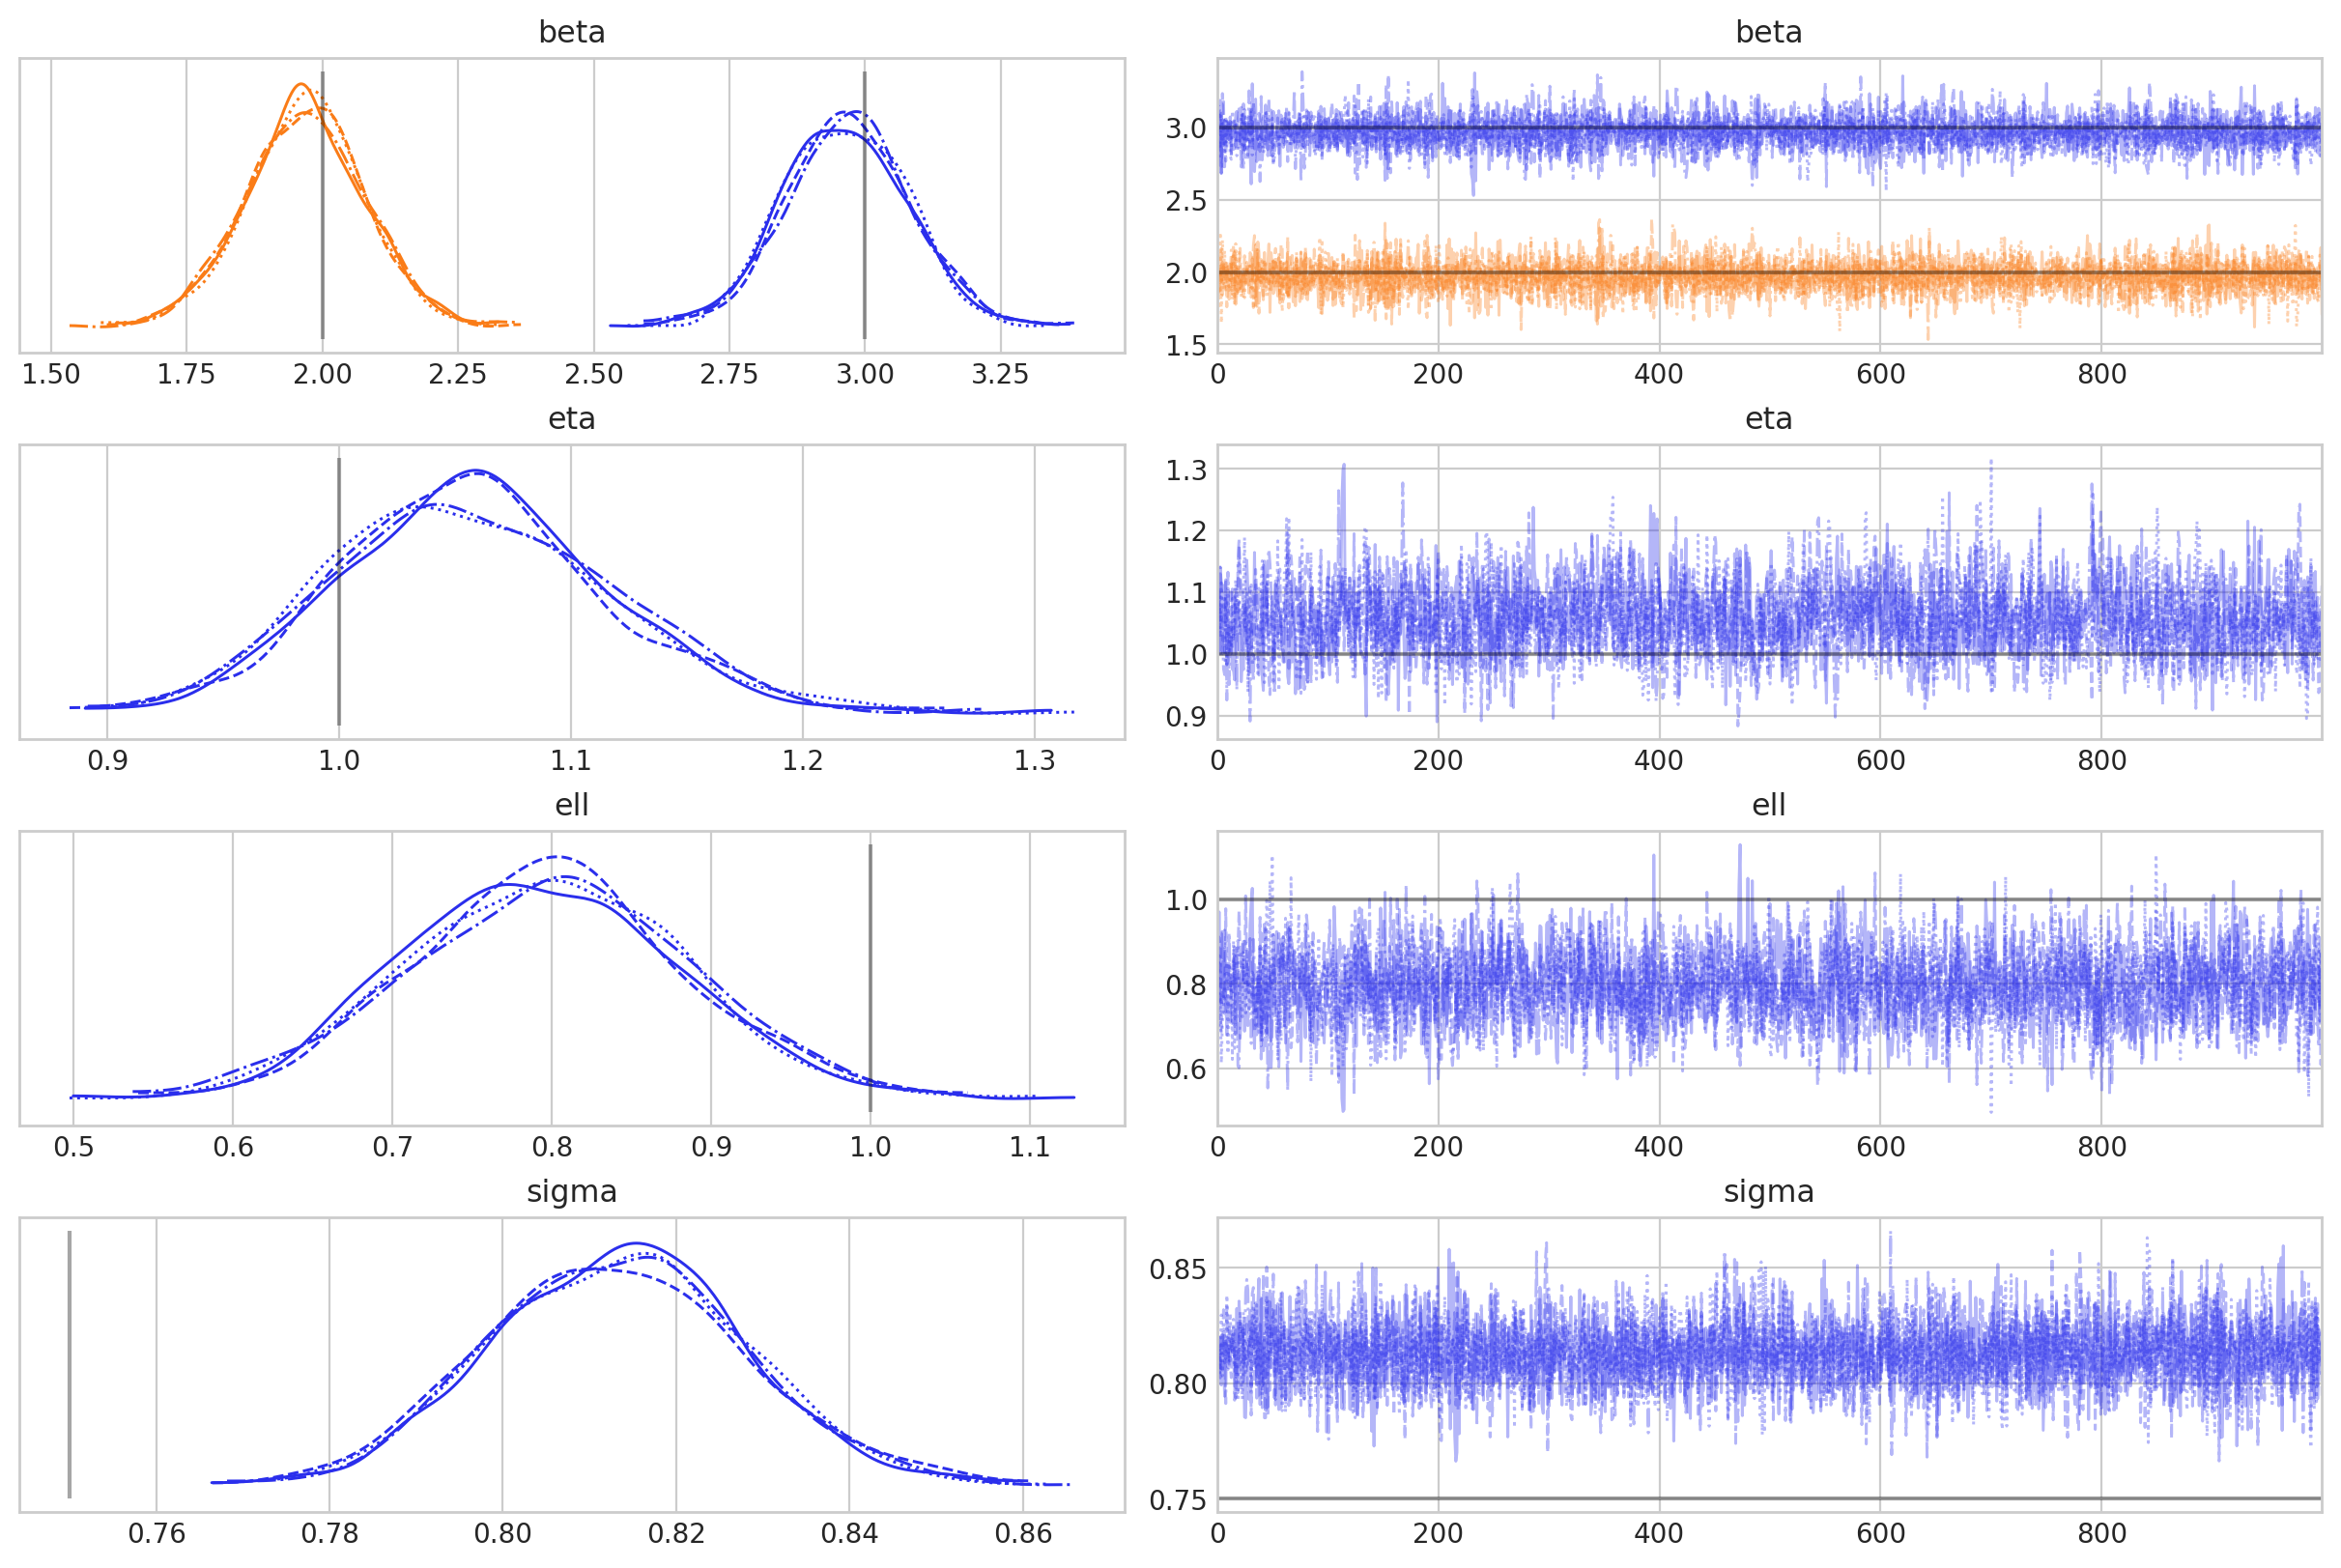

In [22]:
az.plot_trace(
    idata,
    var_names=var_names,
    lines=[("beta", {}, [3, 2]), ("ell", {}, [1]), ("eta", {}, [1]), ("sigma", {}, [0.75])],
);

Sampling went great, but, interestingly, we seem to have a bias in the posterior for `sigma`. It's not the focus of this notebook, but it'd be interesting to dive into this in a real use-case.

### Out-of-sample predictions

Then, we can just use `pm.set_data` to make predictions at new points.  We'll show the fit and the predictions together in the plot below.

In [23]:
with model:
    pm.set_data({"X_gp": X[:, :2], "X_fe": X[:, 2]})

    idata_thinned = idata.sel(draw=slice(None, None, 10))
    idata.extend(
        pm.sample_posterior_predictive(idata_thinned, var_names=["f", "mu"], random_seed=rng)
    )

Sampling: []


Output()

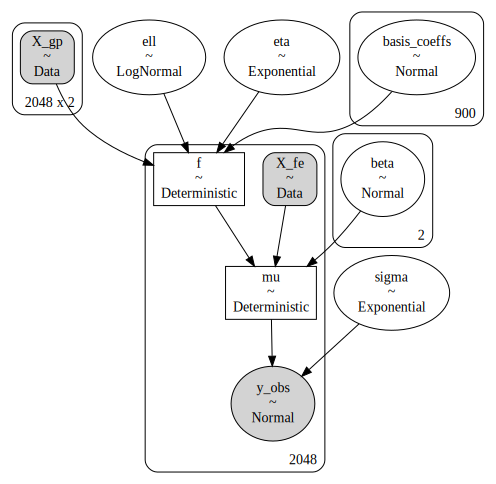

In [24]:
pm.model_to_graphviz(model)

/tmp/ipykernel_21840/3852779046.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.02)


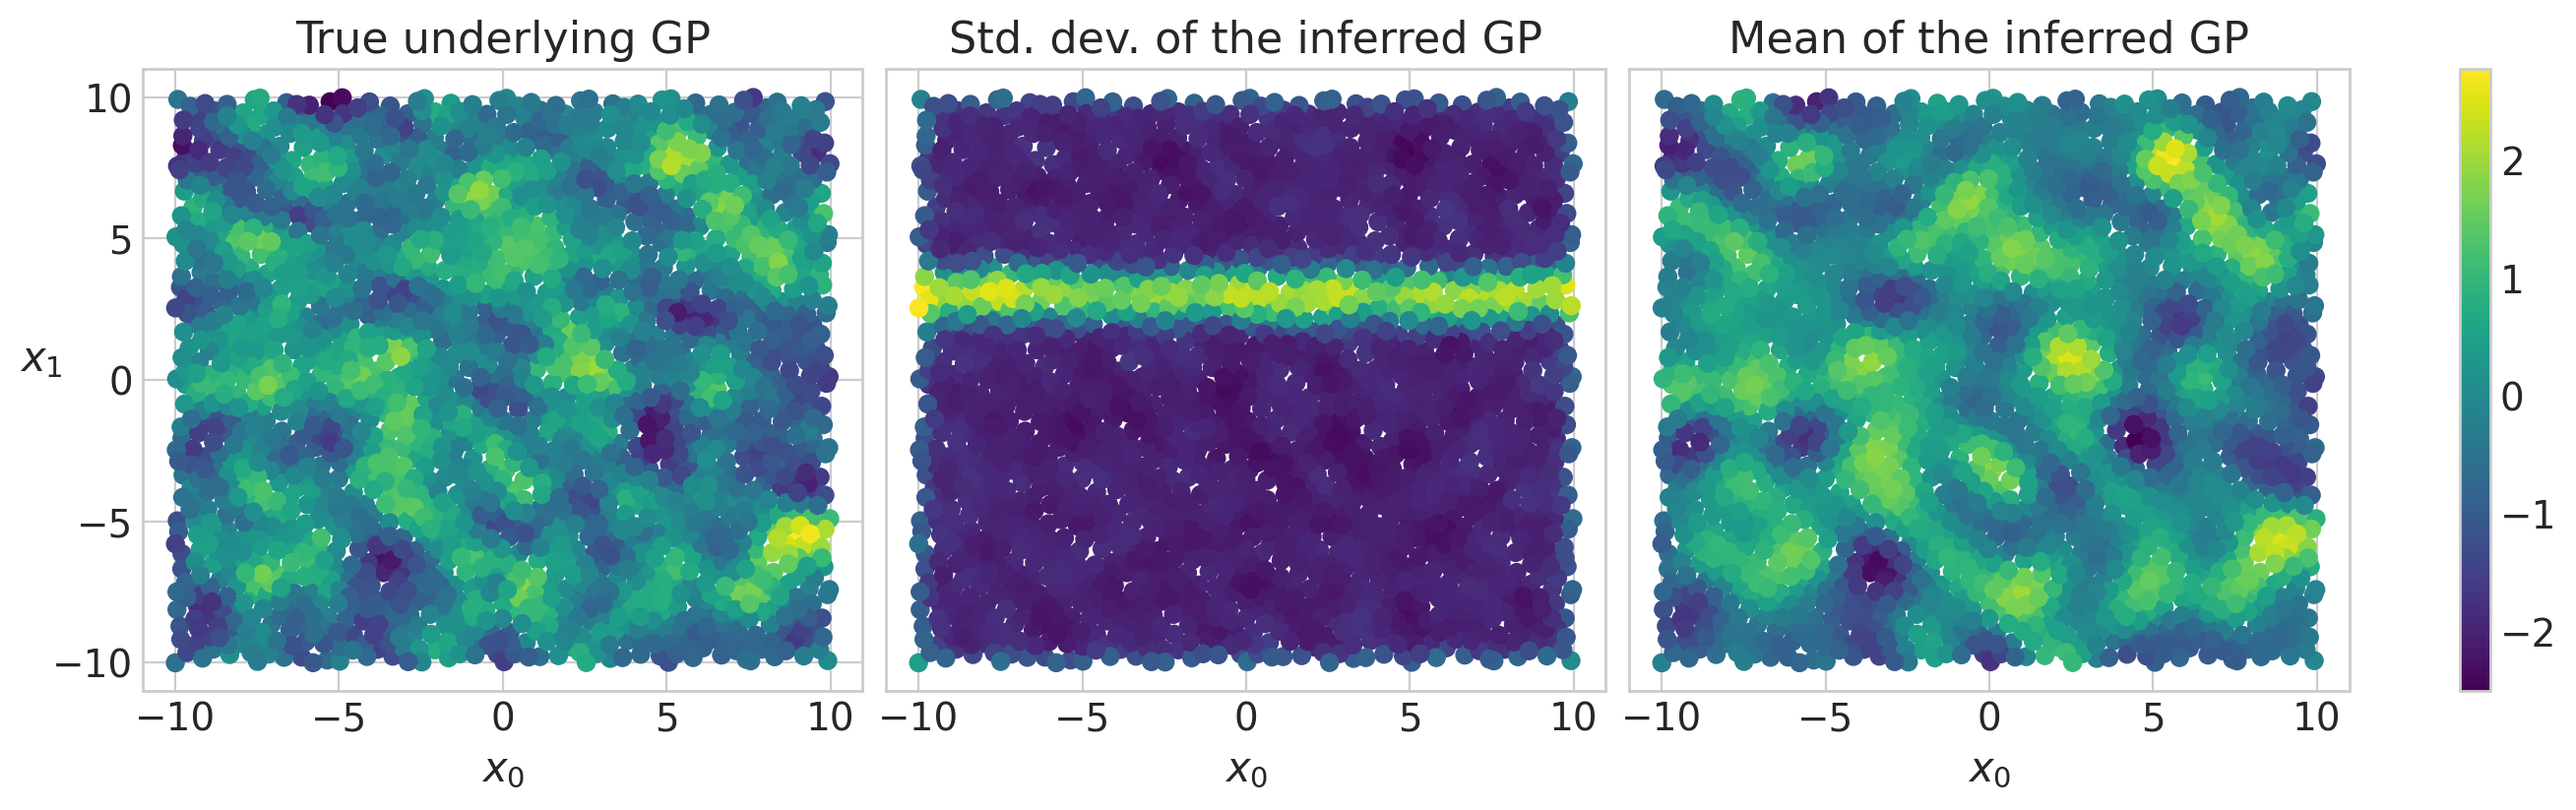

In [25]:
fig = plt.figure(figsize=(13, 4))
plt.subplots_adjust(wspace=0.02)

ax1 = plt.subplot(131)
ax1.scatter(X[:, 0], X[:, 1], c=f_true)
ax1.set_title("True underlying GP")
ax1.set_xlabel("$x_0$")
ax1.set_ylabel("$x_1$", rotation=0)

ax2 = plt.subplot(132)
f_sd = az.extract(idata.posterior_predictive, var_names="f").std(dim="sample")
ax2.scatter(X[:, 0], X[:, 1], c=f_sd)
ax2.set_title("Std. dev. of the inferred GP")
ax2.set_yticks([])
ax2.set_xlabel("$x_0$")

ax3 = plt.subplot(133)
f_mu = az.extract(idata.posterior_predictive, var_names="f").mean(dim="sample")
im = ax3.scatter(X[:, 0], X[:, 1], c=f_mu)
ax3.set_title("Mean of the inferred GP")
ax3.set_yticks([])
ax3.set_xlabel("$x_0$")

fig.colorbar(im, ax=[ax1, ax2, ax3]);

Sampling diagnostics all look good, and we can see that the underlying GP was inferred nicely.  We can also see the increase in uncertainty outside of our training data as a horizontal stripe in the middle panel, showing the increased standard deviation of the inferred GP here. 

## Authors

* Created by [Bill Engels](https://github.com/bwengals) and [Alexandre Andorra](https://github.com/AlexAndorra) in 2024 ([pymc-examples#647](https://github.com/pymc-devs/pymc-examples/pull/647))
* Use `pz.maxent` instead of `pm.find_constrained_prior`, and add random seed. [Osvaldo Martin](https://aloctavodia.github.io/). August 2024

## Watermark

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Sat Aug 17 2024

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.16.1

xarray: 2023.10.1

pytensor  : 2.25.2
matplotlib: 3.8.4
pymc      : 5.16.2+20.g747fda319
numpy     : 1.24.4
preliz    : 0.9.0
arviz     : 0.19.0.dev0

Watermark: 2.4.3



:::{include} ../page_footer.md
:::